In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 05 Bayesian Linear Regression for Student Grade Prediction Part I: EDA

In this notebook, we will develop bayesian linear regression for student grade prediction.  We will conduct EDA to analyze data, develop conventional linear regresion, implement Bayesian Linear Regression using [PyMC3](https://docs.pymc.io/) and interpret the results. What is more, we will show the posterior predictive of a data sample generated by bayesian models could be used as a trigger measure to detect anomaly data (fraud case). It consists of two parts: **Exploratory Data Analysis** (EDA) and **Modeling** parts. 

This is the first part for EDA. 


### Import Libraries

In [ ]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(123)
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['figure.figsize'] = (5, 5)
import seaborn as sns
from IPython.core.pylabtools import figsize
# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

## Dataset
We are using data on student grades collected from a Portuguese secondary (high) school. This data is from the UCI machine learning repository, a great collection of datasets for model testing. 

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details). 

[Source](https://archive.ics.uci.edu/ml/datasets/student+performance)


### Import Libraries

In [ ]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

# EDA

Load data and examine their main characteristic

In [ ]:
import pandas as pd
datafolder = "/content/drive/My Drive/fraud_analysis/datasets/"
file_name = "student-mat.csv"
df_data = pd.read_csv(datafolder + file_name, sep=';', index_col=None)

In [ ]:
df_data.head(2).append(df_data.tail(2))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
393,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0,no,no,no,no,no,yes,yes,no,4,4,1,3,4,5,0,11,12,10
394,MS,M,19,U,LE3,T,1,1,other,at_home,course,father,1,1,0,no,no,no,no,yes,yes,yes,no,3,2,3,3,3,5,5,8,9,9


Here, we will focus on prediction of G3. Filter out grades that were 0

In [ ]:
df_data.rename(columns={'G3': 'Grade'}, inplace=True)
df_data = df_data[~df_data['Grade'].isin([0, 1])]
df_data.head(2).append(df_data.tail(2))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
393,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0,no,no,no,no,no,yes,yes,no,4,4,1,3,4,5,0,11,12,10
394,MS,M,19,U,LE3,T,1,1,other,at_home,course,father,1,1,0,no,no,no,no,yes,yes,yes,no,3,2,3,3,3,5,5,8,9,9


Except target variable **Grade**, the dataset contains lots of student attributes, i.e., features. It mainly consist of two kinds of features:

* Numerical one

  age - student's age 

  studytime - weekly study time
* Categorical one

  higher - wants to take higher education (binary: yes or no) 

  internet - Internet access at home (binary: yes or no) 


### Numerical Features Stats.

In [ ]:
df_data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,16.655462,2.795518,2.546218,1.431373,2.042017,0.271709,3.955182,3.246499,3.098039,1.495798,2.330532,3.549020,6.316527,11.268908,11.358543,11.523810
std,1.268262,1.093999,1.084217,0.686075,0.831895,0.671750,0.885721,1.011601,1.090779,0.919886,1.294974,1.402638,8.187623,3.240450,3.147188,3.227797
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,5.000000,4.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,2.000000,9.000000,9.000000,9.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,14.000000,14.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


### Value Counts for Categorical Columns

In [ ]:
# Print the value counts for categorical columns
for col in df_data.columns:
    if df_data[col].dtype == 'object':
        print('\nColumn Name:', col,)
        print(df_data[col].value_counts())


Column Name: school
GP    315
MS     42
Name: school, dtype: int64

Column Name: sex
F    185
M    172
Name: sex, dtype: int64

Column Name: address
U    279
R     78
Name: address, dtype: int64

Column Name: famsize
GT3    250
LE3    107
Name: famsize, dtype: int64

Column Name: Pstatus
T    318
A     39
Name: Pstatus, dtype: int64

Column Name: Mjob
other       127
services     94
teacher      54
at_home      50
health       32
Name: Mjob, dtype: int64

Column Name: Fjob
other       196
services    100
teacher      26
health       18
at_home      17
Name: Fjob, dtype: int64

Column Name: reason
course        126
reputation     99
home           97
other          35
Name: reason, dtype: int64

Column Name: guardian
mother    248
father     82
other      27
Name: guardian, dtype: int64

Column Name: schoolsup
no     307
yes     50
Name: schoolsup, dtype: int64

Column Name: famsup
yes    219
no     138
Name: famsup, dtype: int64

Column Name: paid
no     184
yes    173
Name: paid, dty

Check Distribution of Grades

In [ ]:
df_data['Grade'].value_counts()

10    56
11    47
15    33
8     32
12    31
13    31
9     28
14    27
16    16
6     15
18    12
7      9
5      7
17     6
19     5
20     1
4      1
Name: Grade, dtype: int64

In [ ]:
df_data['Grade'].describe()

count    357.000000
mean      11.523810
std        3.227797
min        4.000000
25%        9.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: Grade, dtype: float64

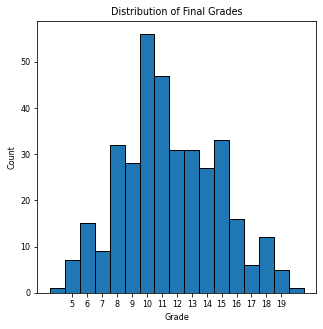

In [ ]:
# Bar plot of grades
plt.bar(df_data['Grade'].value_counts().index, 
        df_data['Grade'].value_counts().values,
         fill = 'navy', edgecolor = 'k', width = 1)
plt.xlabel('Grade'); plt.ylabel('Count'); plt.title('Distribution of Final Grades');
plt.xticks(list(range(5, 20)));

### Group stduents by some attributes and then, check the distributions of grades.

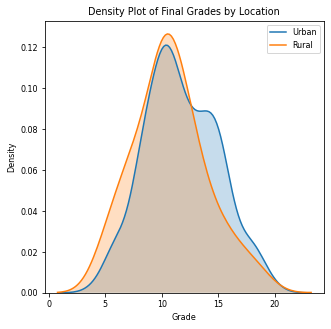

In [ ]:
# Grade distribution by address
sns.kdeplot(df_data.loc[df_data['address'] == 'U', 'Grade'], label = 'Urban', shade = True)
sns.kdeplot(df_data.loc[df_data['address'] == 'R', 'Grade'], label = 'Rural', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot of Final Grades by Location');

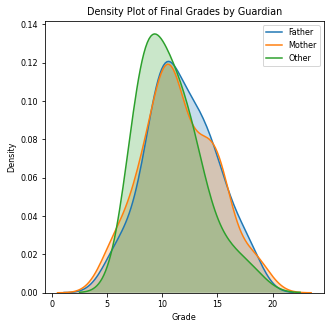

In [ ]:
# Grade distribution by Guardian
sns.kdeplot(df_data.loc[df_data['guardian'] == 'father', 'Grade'], label = 'Father', shade = True)
sns.kdeplot(df_data.loc[df_data['guardian'] == 'mother', 'Grade'], label = 'Mother', shade = True)
sns.kdeplot(df_data.loc[df_data['guardian'] == 'other', 'Grade'], label = 'Other', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot of Final Grades by Guardian');

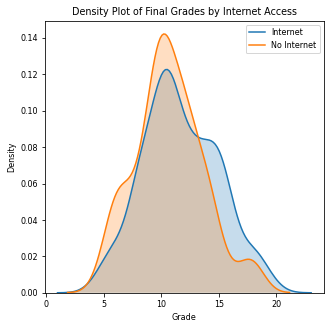

In [ ]:
# Grade distribution by internet
sns.kdeplot(df_data.loc[df_data['internet'] == 'yes', 'Grade'], label = 'Internet', shade = True)
sns.kdeplot(df_data.loc[df_data['internet'] == 'no', 'Grade'], label = 'No Internet', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot of Final Grades by Internet Access');

In [ ]:
# Look at distribution of schools by address
schools = df_data.groupby(['school'])['address'].value_counts()
schools

school  address
GP      U          259
        R           56
MS      R           22
        U           20
Name: address, dtype: int64

### Check percentile for grades

In [ ]:
# Calculate percentile for grades
df_data['percentile'] = df_data['Grade'].apply(lambda x: percentileofscore(df_data['Grade'], x))

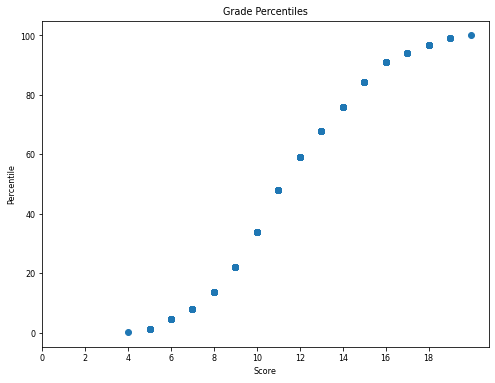

In [ ]:
# Plot percentiles for grades
plt.figure(figsize = (8, 6))
plt.plot(df_data['Grade'], df_data['percentile'], 'o')
plt.xticks(range(0, 20, 2), range(0, 20, 2))
plt.xlabel('Score'); plt.ylabel('Percentile'); plt.title('Grade Percentiles');

In [ ]:
# based on the previous computed percentile
print('50th percentile score:', np.min(df_data.loc[df_data['percentile'] > 50, 'Grade']))
# based on numpy percentile function 
print('Minimum Score needed for 90th percentile:', np.percentile(df_data['Grade'],q=90,axis=0))

50th percentile score: 12
Minimum Score needed for 90th percentile: 16.0


### Categorical Features using One-Hot Encoding

Before machine learning models, we need to convert those categorical features into numerical values. 

Here, we adopt one-hot encoding.

In [ ]:
# Select only categorical variables
category_df = df_data.select_dtypes('object')
category_df.head()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,GT3,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,no,no
1,GP,F,U,GT3,T,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,yes,no,yes,yes,yes,no
3,GP,F,U,GT3,T,health,services,home,mother,no,yes,yes,yes,yes,yes,yes,yes
4,GP,F,U,GT3,T,other,other,home,father,no,yes,yes,no,yes,yes,no,no


In [ ]:
dummy_df = pd.get_dummies(category_df)

In [ ]:
dummy_df.head()

,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0
1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0
2,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0
3,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,1,0


In [ ]:
df_data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'Grade', 'percentile'],
      dtype='object')